In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import seaborn as sns             # visualizations
import matplotlib.pyplot as plt   # visualizations
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

## Uploading data

In [4]:
df = pd.read_csv('Dataset/cardio_train.csv', sep=";")

In [5]:
dfcol=df.columns
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Checking if the targets are balanced

<AxesSubplot:xlabel='cardio', ylabel='count'>

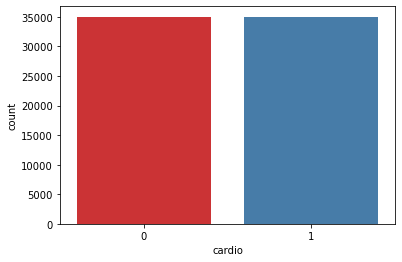

In [6]:
df[["cardio","height"]].groupby("cardio").count()
sns.countplot(x="cardio", data=df, palette="Set1")

## Data Transform (Scaling to avoid outliers)


In [7]:
from sklearn import preprocessing
scaler=preprocessing.MinMaxScaler()
dfscale=scaler.fit_transform(df)
dfscale2=pd.DataFrame(dfscale, columns=dfcol)
dfscale2.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0.00000,0.588076,1.0,0.579487,0.273684,0.016079,0.013550,0.0,0.0,0.0,0.0,1.0,0.0
1,0.00001,0.730159,0.0,0.517949,0.394737,0.017934,0.014453,1.0,0.0,0.0,0.0,1.0,1.0
2,0.00002,0.624003,0.0,0.564103,0.284211,0.017316,0.012647,1.0,0.0,0.0,0.0,0.0,1.0
3,0.00003,0.528455,1.0,0.584615,0.378947,0.018553,0.015357,0.0,0.0,0.0,0.0,1.0,1.0
4,0.00004,0.516918,0.0,0.517949,0.242105,0.015461,0.011743,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting data


In [8]:
xdf=dfscale2.iloc[:,0:11]
ydf=dfscale2.iloc[:,-1]

In [9]:
x_training, x_testing, y_training, y_testing = train_test_split(xdf, ydf, test_size = 0.2, random_state=123, stratify=ydf)

In [10]:
print(xdf.shape)

(70000, 11)


In [11]:
ydf.shape

(70000,)